<p style="text-align: center; font-size:50px;">GAN with landscape images</p>

#### In this notebook, I will be attempting to generate fake landscape images using a GAN trained on 4300 images. 
#### 4300 dataset is definitely not plenty enough for any deep learning task but let us see how far we can go with the data in hand. 

## Inspiration from these papers: 
* [Generative Adversarial Nets](https://arxiv.org/pdf/1406.2661v1.pdf)

* [Unsupervised Representation Learning With Deep Convolutional Generative Adversarial Networks](https://arxiv.org/pdf/1511.06434v2.pdf)


## Data from:
* [Kaggle](https://www.kaggle.com/datasets/arnaud58/landscape-pictures?select=00000000_%283%29.jpg&sort=recent-comments)

In [1]:
%matplotlib inline
import os
from os import listdir
from dotenv import load_dotenv
import pandas as pd 
import numpy as np 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as tt
import matplotlib.pyplot as plt
from torch.utils.data import Dataset as Dataset
from PIL import Image
import torchvision.utils as vutils
from tqdm import tqdm
from torchinfo import summary

<p style="text-align: center; font-size:30px;">Load the Data</p>

#### Let's first create a dataframe to collect our path files for individual images. 

In [2]:
load_dotenv()
path_to_image = os.getenv("LANDSCAPE_PICTURES_PATH")
rows = []

# Creating dataframe
for images in tqdm(os.listdir(path_to_image)):
    if tt.ToTensor()(Image.open(path_to_image + '/' + images)).shape[0] == 3: # Ensuring only images with 3 color channels gets added
        rows.append([str(images)])

image_df = pd.DataFrame(rows, columns=["Path File"])

100%|██████████| 4319/4319 [00:35<00:00, 121.44it/s]


In [3]:
image_df

,Path File
0,00000410_(4).jpg
1,00000017_(5).jpg
2,00000568_(4).jpg
3,00000234_(2).jpg
4,00000633_(3).jpg
...,...
4310,00000144_(4).jpg
4311,00000343.jpg
4312,00000425.jpg
4313,00000367_(3).jpg


#### Let us create our custom Dataset.

In [4]:
image_size = 128

transforming = tt.Compose([
                               tt.Resize(image_size),
                               tt.CenterCrop(image_size),
                               tt.ToTensor(),
                               tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

class GAN(Dataset):
    def __init__(self):
        self.transform = transforming
        self.total_len = image_df.shape[0]
        
    def __len__(self):
        return self.total_len
    
    def __getitem__(self, idx):

        img = self.transform(Image.open(path_to_image + '/' + image_df.iloc[idx].item()))
            
        return img

dataset = GAN()

#### Let's create our DataLoader and visualize some of our training images. 

In [5]:
batch_size = 128

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

# Decide which device we want to run on
device = torch.device("mps")

# Plot some training images
"""real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))"""

'real_batch = next(iter(dataloader))\nplt.figure(figsize=(8,8))\nplt.axis("off")\nplt.title("Training Images")\nplt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))'

In [6]:
image= next(iter(dataloader))

print(f"Image shape: {image.shape} -> [batch_size, color_channels, height, width]")

Image shape: torch.Size([128, 3, 128, 128]) -> [batch_size, color_channels, height, width]


#### Perfect! 
#### Seems like our dataloader is in the condition we want. 

<p style="text-align: center; font-size:30px;">Generator</p>

In [8]:
def weights_init(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 8, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

G = Generator()

In [9]:
summary(G, input_size=(batch_size, nz, 1, 1))

/Users/kimhyunbin/Documents/Python/My own project (Python)/machinelearning/lib/python3.10/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/Users/kimhyunbin/Documents/Python/My own project (Python)/machinelearning/lib/python3.10/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [128, 3, 128, 128]        --
├─Sequential: 1-1                        [128, 3, 128, 128]        --
│    └─ConvTranspose2d: 2-1              [128, 512, 8, 8]          3,276,800
│    └─BatchNorm2d: 2-2                  [128, 512, 8, 8]          1,024
│    └─ReLU: 2-3                         [128, 512, 8, 8]          --
│    └─ConvTranspose2d: 2-4              [128, 256, 16, 16]        2,097,152
│    └─BatchNorm2d: 2-5                  [128, 256, 16, 16]        512
│    └─ReLU: 2-6                         [128, 256, 16, 16]        --
│    └─ConvTranspose2d: 2-7              [128, 128, 32, 32]        524,288
│    └─BatchNorm2d: 2-8                  [128, 128, 32, 32]        256
│    └─ReLU: 2-9                         [128, 128, 32, 32]        --
│    └─ConvTranspose2d: 2-10             [128, 64, 64, 64]         131,072
│    └─BatchNorm2d: 2-11                 [128, 64, 64, 6

torch.Size([3, 128, 128])


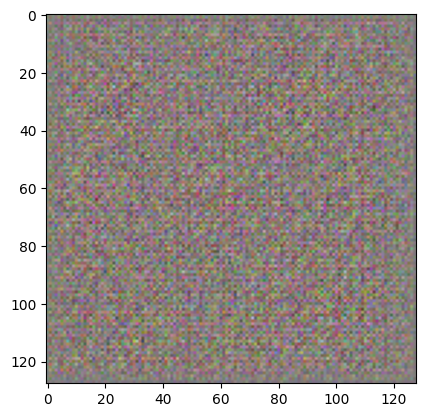

In [12]:
G = Generator().to(device)

G.apply(weights_init)

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

noise = torch.randn(batch_size, nz, 1, 1, device=device)
fake_images = G(noise)
print(fake_images[0].shape)

#plt.imshow(denorm(np.transpose(fake_images[0].cpu().detach(),(1,2,0))))

#### We have a simple Generator above and for now, it is giving us an image with random noises, 400 by 400. 

<p style="text-align: center; font-size:30px;">Discriminator</p>

In [19]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is ``(nc) x 128 x 128``
            nn.Conv2d(nc, ndf, 4, 4, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

D = Discriminator()

summary(D, (batch_size, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [128, 1, 1, 1]            --
├─Sequential: 1-1                        [128, 1, 1, 1]            --
│    └─Conv2d: 2-1                       [128, 64, 32, 32]         3,072
│    └─LeakyReLU: 2-2                    [128, 64, 32, 32]         --
│    └─Conv2d: 2-3                       [128, 128, 16, 16]        131,072
│    └─BatchNorm2d: 2-4                  [128, 128, 16, 16]        256
│    └─LeakyReLU: 2-5                    [128, 128, 16, 16]        --
│    └─Conv2d: 2-6                       [128, 256, 8, 8]          524,288
│    └─BatchNorm2d: 2-7                  [128, 256, 8, 8]          512
│    └─LeakyReLU: 2-8                    [128, 256, 8, 8]          --
│    └─Conv2d: 2-9                       [128, 512, 4, 4]          2,097,152
│    └─BatchNorm2d: 2-10                 [128, 512, 4, 4]          1,024
│    └─LeakyReLU: 2-11                   [128, 512, 4, 4]   

In [20]:
D = Discriminator().to(device)

D.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(4, 4), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

<p style="text-align: center; font-size:30px;">Loss Functions and Optimizers</p>

In [21]:
criterion = nn.BCELoss()

# Creating batch of latent vectors to visualize the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device = device)

real_label = 1.
fake_label = 0. 
lr = 0.0002
beta1 = 0.5

optimizerD = optim.Adam(D.parameters(), lr = lr, betas = (beta1, 0.999))
optimizerG = optim.Adam(G.parameters(), lr = lr, betas = (beta1, 0.999))

<p style="text-align: center; font-size:30px;">Training</p>

In [22]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 200
k = 2 # Hyperparameter according to the paper

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader):
        print(f"Epoch: {epoch}, iteration: {i}")
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        D_x = 0
        D_G_z1 = 0
        errD = 0
        for j in range(k):
        ## Train with all-real batch
            start_idx, end_idx = int(j*(batch_size/k)), int((j+1)*(batch_size/k))
            mini_data = data[start_idx:end_idx]
            D.zero_grad()
            # Format batch
            real_cpu = mini_data.to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            # Forward pass real batch through D
            output = D(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x += output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            # Generate fake image batch with G
            fake = G(noise)
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = D(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 += output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD += (errD_real + errD_fake)
            # Update D
            optimizerD.step()
        D_x /= k
        D_G_z1 /= k
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = D(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 10 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 10 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = G(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
Epoch: 0, iteration: 0
[0/200][0/34]	Loss_D: 2.1900	Loss_G: 4.5723	D(x): 0.6615	D(G(z)): 0.3194 / 0.0153
Epoch: 0, iteration: 1
Epoch: 0, iteration: 2
Epoch: 0, iteration: 3
Epoch: 0, iteration: 4
Epoch: 0, iteration: 5
Epoch: 0, iteration: 6
Epoch: 0, iteration: 7
Epoch: 0, iteration: 8
Epoch: 0, iteration: 9
Epoch: 0, iteration: 10
[0/200][10/34]	Loss_D: 0.1863	Loss_G: 5.7413	D(x): 0.9426	D(G(z)): 0.0103 / 0.0061
Epoch: 0, iteration: 11
Epoch: 0, iteration: 12
Epoch: 0, iteration: 13
Epoch: 0, iteration: 14
Epoch: 0, iteration: 15
Epoch: 0, iteration: 16
Epoch: 0, iteration: 17
Epoch: 0, iteration: 18
Epoch: 0, iteration: 19
Epoch: 0, iteration: 20
[0/200][20/34]	Loss_D: 0.0784	Loss_G: 6.5129	D(x): 0.9771	D(G(z)): 0.0055 / 0.0026
Epoch: 0, iteration: 21
Epoch: 0, iteration: 22
Epoch: 0, iteration: 23
Epoch: 0, iteration: 24
Epoch: 0, iteration: 25
Epoch: 0, iteration: 26
Epoch: 0, iteration: 27
Epoch: 0, iteration: 28
Epoch: 0, iteration: 29
Epoch: 0, iterat

<p style="text-align: center; font-size:30px;">Results</p>

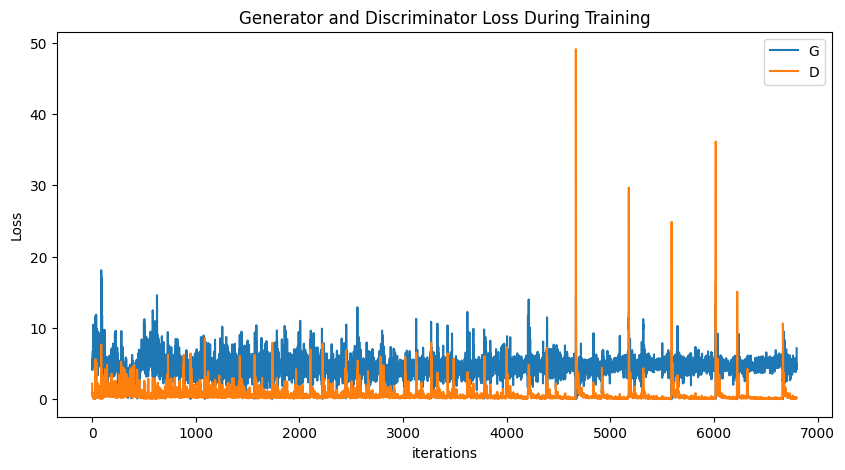

In [35]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

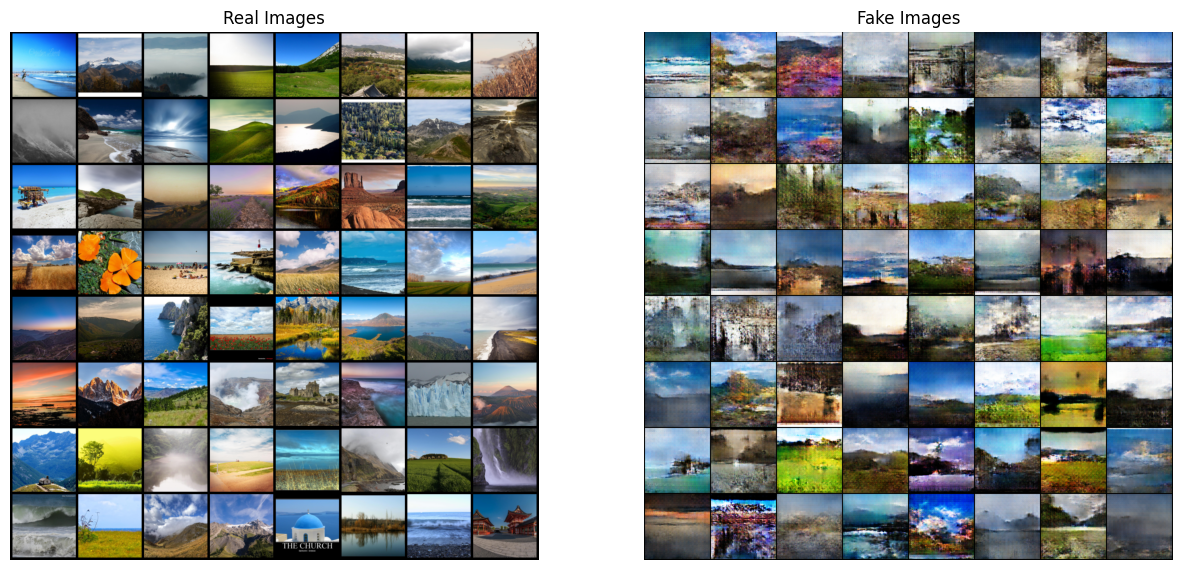

In [23]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

#### Let's try to plot a single image.

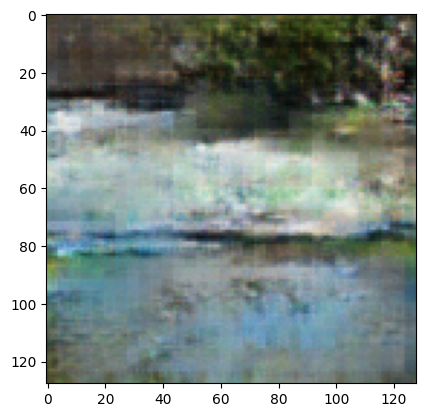

In [34]:
noise = torch.randn(b_size, nz, 1, 1, device=device)
fake_images = G(noise)

plt.imshow(denorm(np.transpose(fake_images[0].cpu().detach(),(1,2,0))))